# Planetary Training

This second model looks for difference in using pretrained weights

In [2]:
%load_ext autoreload
%autoreload 2

import importlib    

# check if it is using CPU or GPU
# First the CPU version
if importlib.util.find_spec('torch') is None:
    %pip install --quiet torch torchvision --extra-index-url https://download.pytorch.org/whl/cpu


if importlib.util.find_spec('fastai') is None:
    # Then install fastai from code
    !cd /tmp; git clone https://github.com/fastai/fastai -q
    %pip -q install -e /tmp/fastai 

# Install WaterNet
if importlib.util.find_spec('waternet') is None:
    %pip install -e /home/jovyan/projects/WaterNet/
    
from waternet.wndataset import WNDataSet
from fastai.vision.all import *



### Creating the Datasets

In [3]:
masks_path = '/home/jovyan/tmp3'
training_bands = ['B04', 'B03', 'B02', 'B08', 'B11', 'B12']
# masks_path='d:/temp/22KEV/'

In [4]:
# default config for shape, size and step
config = dict(
    shape=(5490, 5490),
    patch_size=(512, 512),
    step=262,    
)

# 2018 october for training
train_ds = WNDataSet.from_masks(
    masks_path=masks_path,
    pattern='*S2A*watermask.tif',
    **config
)

Matching imgs/masks:   0%|          | 0/106 [00:00<?, ?it/s]

In [5]:
# a single image for the validation
valid_ds = WNDataSet.from_masks(
    masks_path=masks_path,
    pattern='*S2B_MSIL2A_2021*watermask.tif',
    **config
)

Matching imgs/masks:   0%|          | 0/25 [00:00<?, ?it/s]

In [6]:
train_ds.bands = training_bands
valid_ds.bands = training_bands

print(train_ds)
print(valid_ds)

WNDataset instance with 106 images
Loaded: 0 items
Empty: 106 items
Loading: 0 items

WNDataset instance with 25 images
Loaded: 0 items
Empty: 25 items
Loading: 0 items



### Creating Dataloaders

In [8]:
# Create two dataloaders (for training and validation)
# Put it in the GPU
dls = DataLoaders(
    DataLoader(train_ds, bs=6),
    DataLoader(valid_ds, bs=6)
) # .cuda()

In [7]:
# m, t = dls.valid.one_batch()
# m.device

In [8]:
# dls.train.one_batch()[0].shape

### Creating the Learner

In [9]:
learner = unet_learner(
    dls, arch=resnet18, pretrained=True, normalize=False, n_in=6, n_out=3, loss_func=CrossEntropyLossFlat(axis=1)
)

Loading image 1 in background


/srv/conda/envs/notebook/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
cuda_model = learner.cuda()
learner.dls = learner.dls.cuda()

Loaded sucessfully


### Checking model and predictions

In [17]:
learner.unfreeze()

In [18]:
learner.summary()

DynamicUnet (Input shape: 8 x 6 x 512 x 512)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 256 x 256  
Conv2d                                    18816      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 128 x 128  
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

In [10]:
batch, target = dls.train.one_batch()
print(batch.shape, target.shape)

torch.Size([8, 6, 512, 512]) torch.Size([8, 512, 512])


In [11]:
# Calculate the predictions for the 4 patches (1 batch)
pred = learner.model(batch)
pred.shape

torch.Size([8, 3, 512, 512])

In [12]:
CrossEntropyLossFlat(axis=1)(pred, target)

TensorBase(1.6239, grad_fn=<AliasBackward0>)

### Running LrFind

Up to now, evertying was done in the CPU, but to run large amounts, it is necessary to load the data in the Cuda device. For that we will put them in the GPU and find the best learning rate.

Cleared image 0
Loading image 2 in background
Loaded sucessfully


SuggestedLRs(valley=7.585775892948732e-05)

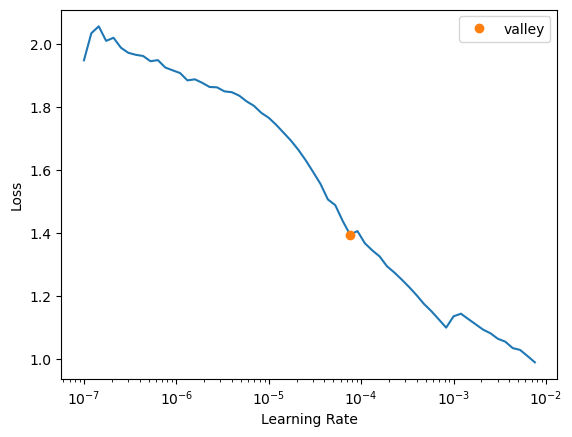

In [16]:
learner.lr_find()

In [ ]:
learner.fit_one_cycle(1, lr_max=2e-4)

epoch,train_loss,valid_loss,time


Cleared image 0
Loading image 2 in background
Loaded sucessfully
Cleared image 1
Loading image 3 in background
Loaded sucessfully
Cleared image 2
Loading image 4 in background
Loaded sucessfully
Cleared image 3
Loading image 5 in background
Loaded sucessfully
Cleared image 4
Loading image 6 in background
Loaded sucessfully
Cleared image 5
Loading image 7 in background
Loaded sucessfully
Cleared image 6
Loading image 8 in background
Loaded sucessfully
Cleared image 7
Loading image 9 in background
Loaded sucessfully
Cleared image 8
Loading image 10 in background
Loaded sucessfully
Cleared image 9
Loading image 11 in background
Loaded sucessfully
Cleared image 10
Loading image 12 in background
Loaded sucessfully
Cleared image 11
Loading image 13 in background
Loaded sucessfully
Cleared image 12
Loading image 14 in background
Loaded sucessfully
Cleared image 13
Loading image 15 in background
Loaded sucessfully
Cleared image 14
Loading image 16 in background
Loaded sucessfully
Cleared image

In [ ]:
learner.save('Resnet18-6chnls-trained')

### Como ver os resultados???

In [ ]:
from waternet.wnvisualizer import WNVisualizer

In [ ]:
learner = unet_learner(
    dls, arch=resnet18, pretrained=False, normalize=False, n_in=6, n_out=3, loss_func=CrossEntropyLossFlat(axis=1)
)
learner.load('Resnet18-6chnls-trained')
model = learner.cpu()

In [ ]:
visu = WNVisualizer(dls.valid, learner)

In [ ]:
visu.predict_item(0)['item'].shape

In [ ]:
visu.show_pred(800)

In [ ]:
dls.valid.dataset.loaded_status